In [1]:
import colorsys
import os

import gradio as gr
import matplotlib.colors as mcolors
import numpy as np
import spaces
import torch
from gradio.themes.utils import sizes
from PIL import Image
from torchvision import transforms
from config import LABELS_TO_IDS
from utils.vis_utils import get_palette, visualize_mask_with_overlay

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available() and torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [3]:
from config import SAPIENS_LITE_MODELS_PATH

def get_model_path(task, version):
    try:
        model_path = SAPIENS_LITE_MODELS_PATH[task][version]
        if not os.path.exists(model_path):
            print(f"Warning: The model file does not exist at {model_path}")
        return model_path
    except KeyError as e:
        print(f"Error: Invalid task or version. {e}")
        return None

# Example usage
TASK = 'seg'
VERSION = 'sapiens_0.3b'

model_path = get_model_path(TASK, VERSION)
print(model_path)

checkpoints/seg/sapiens_0.3b_torchscript.pt2


In [4]:
model = torch.jit.load(model_path)
model.eval()
model.to("cuda")

RecursiveScriptModule(
  original_name=EncoderDecoder
  (data_preprocessor): RecursiveScriptModule(original_name=SegDataPreProcessor)
  (backbone): RecursiveScriptModule(
    original_name=VisionTransformer
    (patch_embed): RecursiveScriptModule(
      original_name=PatchEmbed
      (adaptive_padding): RecursiveScriptModule(original_name=AdaptivePadding)
      (projection): RecursiveScriptModule(original_name=Conv2d)
    )
    (drop_after_pos): RecursiveScriptModule(original_name=Dropout)
    (layers): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        original_name=TransformerEncoderLayer
        (ln1): RecursiveScriptModule(original_name=LayerNorm)
        (attn): RecursiveScriptModule(
          original_name=MultiheadAttention
          (qkv): RecursiveScriptModule(original_name=Linear)
          (proj): RecursiveScriptModule(original_name=Linear)
          (proj_drop): RecursiveScriptModule(original_name=Dropout)
          (out_drop):

In [5]:
@torch.inference_mode()
def run_model(input_tensor, height, width):
    output = model(input_tensor)
    output = torch.nn.functional.interpolate(output, size=(height, width), mode="bilinear", align_corners=False)
    _, preds = torch.max(output, 1)
    return preds

In [6]:
transform_fn = transforms.Compose(
    [
        transforms.Resize((1024, 768)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [7]:
def segment(image):
    input_tensor = transform_fn(image).unsqueeze(0).to("cuda")

    preds = run_model(input_tensor, height=image.height, width=image.width)
    mask = preds.squeeze(0).cpu().numpy()

    mask_image = Image.fromarray(mask.astype("uint8"))
    blended_image = visualize_mask_with_overlay(image, mask_image, LABELS_TO_IDS, alpha=0.5)
    return blended_image

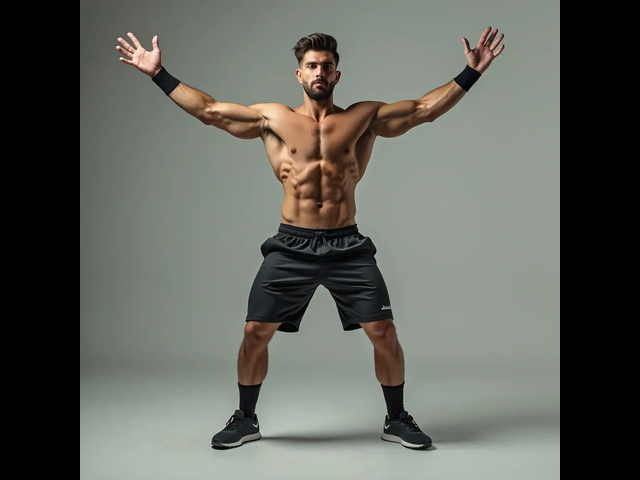

In [8]:
from utils.vis_utils import resize_image
pil_image = Image.open('/home/user/app/assets/image.webp')

if pil_image.mode == 'RGBA':
    pil_image = pil_image.convert('RGB')

resized_pil_image = resize_image(pil_image, (640, 480))
resized_pil_image

In [9]:
output_image = segment(pil_image)

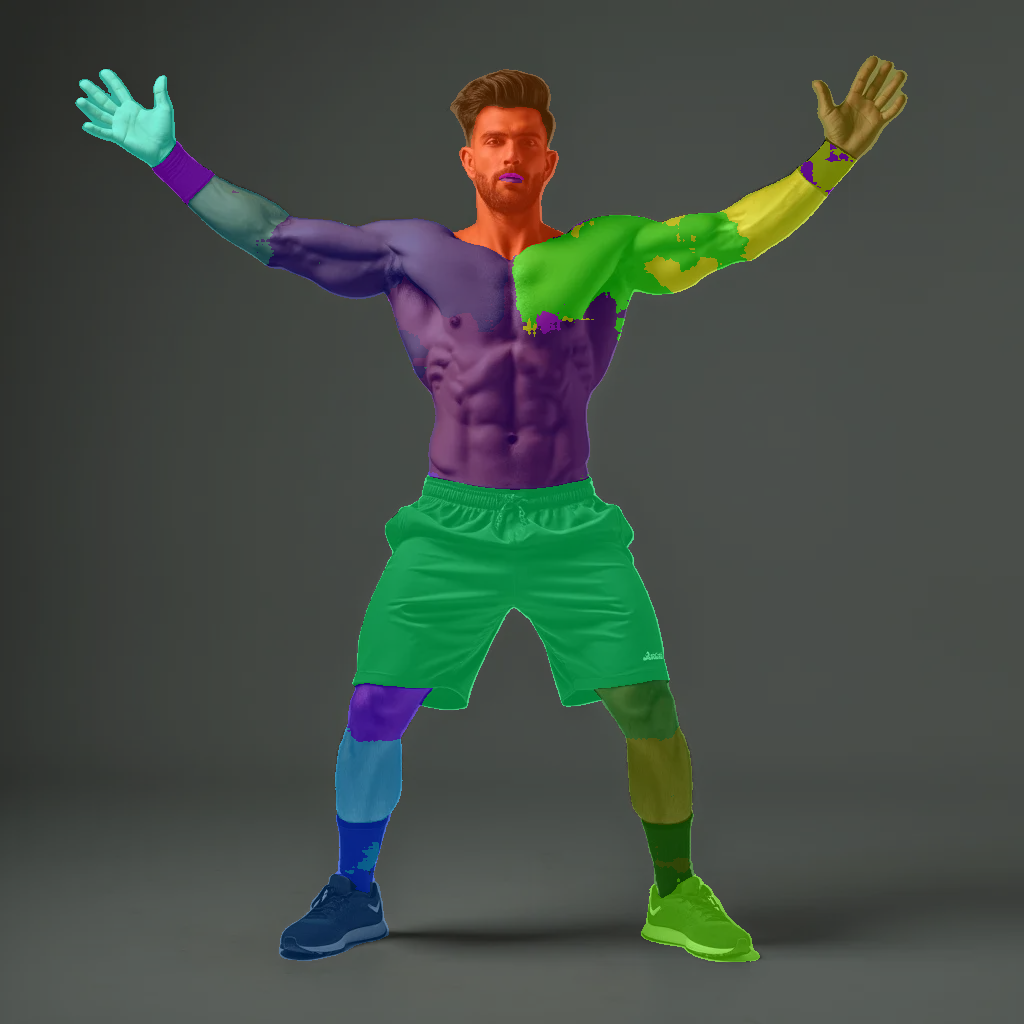

In [10]:
output_image

# POSE